In [1]:
!nvidia-smi

Tue Oct 17 11:33:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8               7W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!dir pubmed-rct

 Volume in drive C is Acer
 Volume Serial Number is A4D6-E32A

 Directory of C:\Users\manda\OneDrive\Desktop\Files\TensorFlow Developer Certificate in 2023 Zero to Mastery\My files\pubmed-rct

02-10-2023  11:25    <DIR>          .
17-10-2023  11:30    <DIR>          ..
02-10-2023  11:25    <DIR>          PubMed_200k_RCT
02-10-2023  11:25    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
02-10-2023  11:25    <DIR>          PubMed_20k_RCT
02-10-2023  11:25    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
02-10-2023  11:25             2,403 README.md
               1 File(s)          2,403 bytes
               6 Dir(s)  272,972,558,336 bytes free


In [3]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [4]:
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [5]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else:
            abstract_lines += line

    return abstract_samples
            

In [7]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: total: 78.1 ms
Wall time: 385 ms


(180040, 30212, 30135)

In [8]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [10]:
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='Count'>

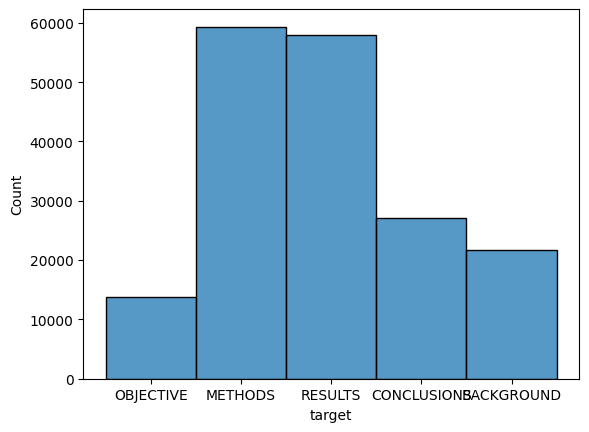

In [11]:
import seaborn as sns
sns.histplot(train_df['target'])

<Axes: xlabel='total_lines', ylabel='Count'>

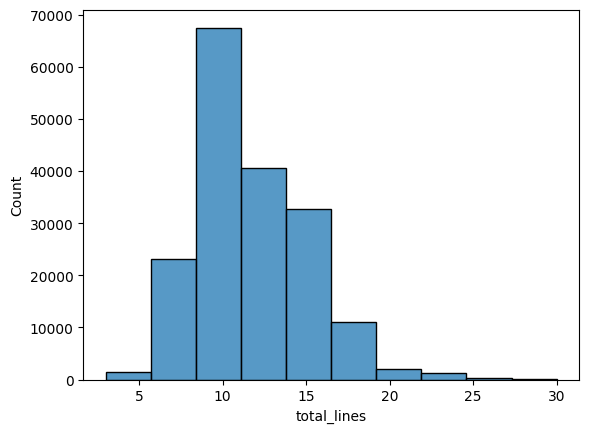

In [12]:
sns.histplot(train_df['total_lines'],bins=10)

In [13]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [14]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [15]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [16]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [18]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sentences, y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
from helper_functions import *

In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [25]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

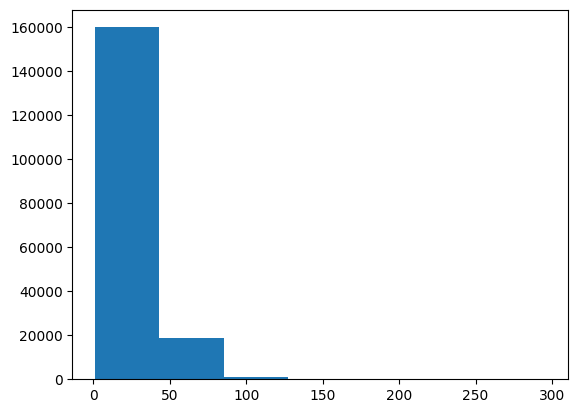

In [28]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7)

In [29]:
max(sent_lens)

296

In [30]:
max_tokens = 68000

In [31]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=55)

In [32]:
text_vectorizer.adapt(train_sentences)

In [33]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
at final follow-up ( average @ months ) , patients underwent a clinical and radiographic evaluation .

Length of text: 17

Vectorized text:
[[  15  816   94  405   41   12  352    8   47    3 1893  381    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [36]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [37]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
at final follow-up ( average @ months ) , patients underwent a clinical and radiographic evaluation .

Sentence after vectorization (before embedding):
[[  15  816   94  405   41   12  352    8   47    3 1893  381    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.00075136  0.00587865 -0.01667533 ... -0.00353805 -0.04349769
    0.04696542]
  [ 0.03055737  0.04566009 -0.04989542 ... -0.00674806 -0.04742949
   -0.03201897]
  [ 0.04268539 -0.02367934  0.01731152 ... -0.03190507 -0.03287629
    0.01627531]
  ...
  [-0.03623078  0.00196026 -0.02167631 ... -0.0226073  -0.00259297
   -0.00412946]
  [-0.03623078  0.00196026 -0.02167631 ... -0.0226073  -0.00259297
   -0.00412946]
  [-0.03623078  0.00196026 -0.02167631 ... -0.0226073  -0.00259297
   -0.00412946]]]

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [40]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 10ms/step - loss: 0.9170 - accuracy: 0.6371 - val_loss: 0.6902 - val_accuracy: 0.7327
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6599 - accuracy: 0.7556 - val_loss: 0.6354 - val_accuracy: 0.7673
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6173 - accuracy: 0.7746 - val_loss: 0.5962 - val_accuracy: 0.7819


In [43]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5972 - accuracy: 0.7874


[0.5972176790237427, 0.787402331829071]

In [44]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.5477897e-01, 1.8022849e-01, 5.6269448e-02, 2.8809547e-01,
        2.0627612e-02],
       [3.8046092e-01, 3.5745198e-01, 1.2801846e-02, 2.3883572e-01,
        1.0449523e-02],
       [1.6486536e-01, 4.9047554e-03, 1.4534056e-03, 8.2874382e-01,
        3.2710297e-05],
       ...,
       [6.7006376e-06, 1.0783699e-03, 7.3068554e-04, 3.8850835e-06,
        9.9818039e-01],
       [5.0078381e-02, 4.5470881e-01, 7.7443205e-02, 6.1188925e-02,
        3.5658076e-01],
       [2.1591152e-01, 6.2845957e-01, 5.6038767e-02, 5.9992399e-02,
        3.9597701e-02]], dtype=float32)

In [45]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [46]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74023566794651,
 'precision': 0.7844152546574019,
 'recall': 0.7874023566794651,
 'f1': 0.7848489150364685}

In [47]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [48]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("universal-sentence-encoder_4", #Manually downloaded the model to run in local machine
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
a parenteral lipid emulsion with a multicomponent composition may improve growth and neurodevelopment and may prevent liver injury , which is often observed in association with long-term parenteral nutrition with pure soybean oil .

Sentence after embedding:
[-0.00344208  0.01002462  0.00727834 -0.07315469 -0.03847757 -0.01901804
  0.02846831 -0.01323026  0.04089104  0.02881735  0.07223867  0.00666994
 -0.05231314  0.07306693 -0.08548545 -0.01627151 -0.08641548 -0.00378162
  0.00186822 -0.02371012 -0.00517942  0.02355253  0.01376722 -0.01666966
  0.00366611 -0.0320485  -0.0184071  -0.0115243  -0.07597645  0.00507476] (truncated output)...

Length of sentence embedding:
512


In [50]:
inputs = tf.keras.layers.Input(shape = [], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

In [51]:
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = (0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = (0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 13ms/step - loss: 0.9150 - accuracy: 0.6515 - val_loss: 0.8067 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7722 - accuracy: 0.6996 - val_loss: 0.7638 - val_accuracy: 0.7043
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7560 - accuracy: 0.7105 - val_loss: 0.7456 - val_accuracy: 0.7122


In [52]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7447 - accuracy: 0.7124


[0.744694709777832, 0.7124321460723877]

In [53]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[0.43348798, 0.3753142 , 0.00310332, 0.18023278, 0.00786177],
       [0.35605165, 0.48084083, 0.00479168, 0.15554306, 0.00277282],
       [0.23731305, 0.15856977, 0.02262622, 0.5411497 , 0.0403413 ],
       ...,
       [0.00188728, 0.00688656, 0.05042187, 0.00102501, 0.9397793 ],
       [0.00392529, 0.04886526, 0.20852701, 0.00166073, 0.73702174],
       [0.17859797, 0.2381536 , 0.518595  , 0.00643092, 0.05822253]],
      dtype=float32)

In [54]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [55]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.2432146167086,
 'precision': 0.7136279925831415,
 'recall': 0.712432146167086,
 'f1': 0.7095858117152437}

In [56]:
def split_chars(text):
    return " ".join(list(text))

In [57]:
random_training_sentence

'a parenteral lipid emulsion with a multicomponent composition may improve growth and neurodevelopment and may prevent liver injury , which is often observed in association with long-term parenteral nutrition with pure soybean oil .'

In [58]:
split_chars(random_training_sentence)

'a   p a r e n t e r a l   l i p i d   e m u l s i o n   w i t h   a   m u l t i c o m p o n e n t   c o m p o s i t i o n   m a y   i m p r o v e   g r o w t h   a n d   n e u r o d e v e l o p m e n t   a n d   m a y   p r e v e n t   l i v e r   i n j u r y   ,   w h i c h   i s   o f t e n   o b s e r v e d   i n   a s s o c i a t i o n   w i t h   l o n g - t e r m   p a r e n t e r a l   n u t r i t i o n   w i t h   p u r e   s o y b e a n   o i l   .'

In [59]:
list(random_training_sentence)

['a',
 ' ',
 'p',
 'a',
 'r',
 'e',
 'n',
 't',
 'e',
 'r',
 'a',
 'l',
 ' ',
 'l',
 'i',
 'p',
 'i',
 'd',
 ' ',
 'e',
 'm',
 'u',
 'l',
 's',
 'i',
 'o',
 'n',
 ' ',
 'w',
 'i',
 't',
 'h',
 ' ',
 'a',
 ' ',
 'm',
 'u',
 'l',
 't',
 'i',
 'c',
 'o',
 'm',
 'p',
 'o',
 'n',
 'e',
 'n',
 't',
 ' ',
 'c',
 'o',
 'm',
 'p',
 'o',
 's',
 'i',
 't',
 'i',
 'o',
 'n',
 ' ',
 'm',
 'a',
 'y',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'e',
 ' ',
 'g',
 'r',
 'o',
 'w',
 't',
 'h',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'n',
 'e',
 'u',
 'r',
 'o',
 'd',
 'e',
 'v',
 'e',
 'l',
 'o',
 'p',
 'm',
 'e',
 'n',
 't',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'm',
 'a',
 'y',
 ' ',
 'p',
 'r',
 'e',
 'v',
 'e',
 'n',
 't',
 ' ',
 'l',
 'i',
 'v',
 'e',
 'r',
 ' ',
 'i',
 'n',
 'j',
 'u',
 'r',
 'y',
 ' ',
 ',',
 ' ',
 'w',
 'h',
 'i',
 'c',
 'h',
 ' ',
 'i',
 's',
 ' ',
 'o',
 'f',
 't',
 'e',
 'n',
 ' ',
 'o',
 'b',
 's',
 'e',
 'r',
 'v',
 'e',
 'd',
 ' ',
 'i',
 'n',
 ' ',
 'a',
 's',
 's',
 'o',
 'c',
 'i',
 'a'

In [60]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [62]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

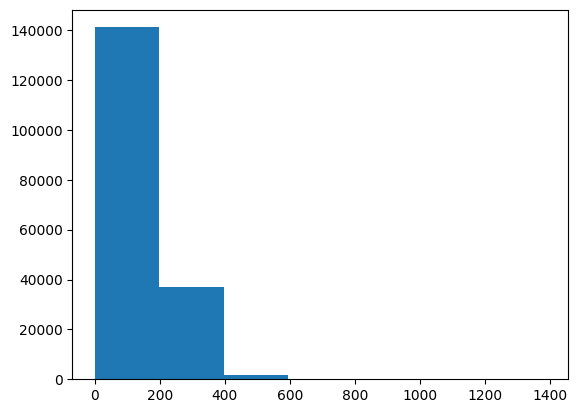

In [63]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [64]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [67]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [68]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
g e n e r a l   s y m p t o m s   i n   p d   a l s o   i m p r o v e d   .

Length of chars: 32

Vectorized chars:
[[18  2  6  2  8  5 12  9 19 15 14  3  7 15  9  4  6 14 10  5 12  9  7  4
  15 14  8  7 21  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [69]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                             output_dim=25,
                             mask_zero=True,
                             name="char_method")

In [70]:
print(f"Charified texr: \n {random_train_chars} \n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified texr: 
 g e n e r a l   s y m p t o m s   i n   p d   a l s o   i m p r o v e d   . 

Embedded chars (after vectorization and embedding):
[[[ 0.02313353  0.01232911 -0.00162907 ... -0.02208116  0.02799023
    0.01903064]
  [ 0.02550293  0.01395655  0.04985983 ...  0.00447682  0.01400885
    0.02337334]
  [-0.04175047  0.01658851 -0.02970351 ...  0.03651894  0.00279959
   -0.00699726]
  ...
  [ 0.03720773  0.03718907 -0.04060162 ... -0.04028352 -0.04394176
   -0.03585332]
  [ 0.03720773  0.03718907 -0.04060162 ... -0.04028352 -0.04394176
   -0.03585332]
  [ 0.03720773  0.03718907 -0.04060162 ... -0.04028352 -0.04394176
   -0.03585332]]]

Character embedding shape: (1, 290, 25)


In [71]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

In [72]:
model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [73]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_method (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [74]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [75]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 4ms/step - loss: 1.2621 - accuracy: 0.4927 - val_loss: 1.0575 - val_accuracy: 0.5781
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0256 - accuracy: 0.5892 - val_loss: 0.9513 - val_accuracy: 0.6310
Epoch 3/3
562/562 [==============================] - 2s 4ms/step - loss: 0.9389 - accuracy: 0.6335 - val_loss: 0.8769 - val_accuracy: 0.6622


In [76]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 2s 3ms/step - loss: 0.8974 - accuracy: 0.6513


[0.8974083065986633, 0.6512643694877625]

In [77]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.14256594, 0.42718622, 0.17197353, 0.18487205, 0.07340229],
       [0.1295308 , 0.39067858, 0.01982147, 0.40407783, 0.05589137],
       [0.05689066, 0.06932759, 0.35528624, 0.4721583 , 0.04633726],
       ...,
       [0.02938617, 0.03474853, 0.26984912, 0.02793321, 0.638083  ],
       [0.04874828, 0.10362753, 0.36731344, 0.05261212, 0.42769867],
       [0.38828078, 0.46535626, 0.06086767, 0.06195034, 0.02354491]],
      dtype=float32)

In [78]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 1], dtype=int64)>

In [79]:
model_3_results = calculate_results(y_true=val_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 65.12643982523501,
 'precision': 0.6471017661730942,
 'recall': 0.65126439825235,
 'f1': 0.6410732810885617}

In [80]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [81]:
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

In [82]:
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [83]:
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [84]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [85]:
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input], 
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

In [86]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

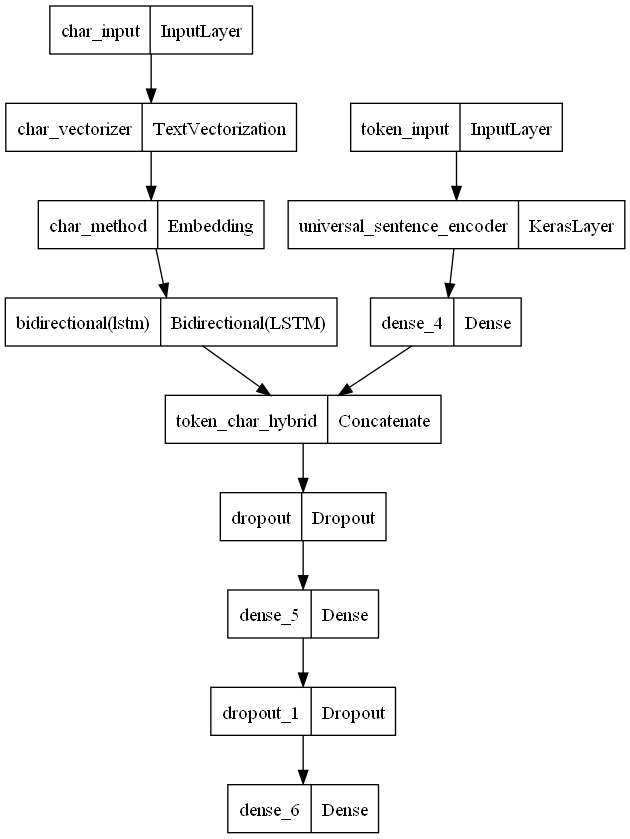

In [87]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [88]:
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam", 
                metrics=["accuracy"])

In [89]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [90]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [92]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_batch_size=(0.1*len(val_char_token_data)))

Epoch 1/3
562/562 [==============================] - 56s 91ms/step - loss: 0.9604 - accuracy: 0.6182 - val_loss: 0.7783 - val_accuracy: 0.7013
Epoch 2/3
562/562 [==============================] - 59s 105ms/step - loss: 0.7901 - accuracy: 0.6924 - val_loss: 0.7134 - val_accuracy: 0.7298
Epoch 3/3
562/562 [==============================] - 52s 93ms/step - loss: 0.7634 - accuracy: 0.7075 - val_loss: 0.6918 - val_accuracy: 0.7354


In [93]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 29s 30ms/step - loss: 0.6918 - accuracy: 0.7354


[0.6917532086372375, 0.7353700399398804]

In [94]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 29s 29ms/step


array([[4.1208696e-01, 4.2558289e-01, 3.9591664e-03, 1.4907838e-01,
        9.2926417e-03],
       [3.7882203e-01, 3.6809450e-01, 6.2154215e-03, 2.4428102e-01,
        2.5869585e-03],
       [3.4418413e-01, 1.5676999e-01, 5.5980839e-02, 4.1251525e-01,
        3.0549843e-02],
       ...,
       [9.5076754e-04, 1.2707386e-02, 6.6425979e-02, 4.0924601e-04,
        9.1950661e-01],
       [9.3710860e-03, 5.8011375e-02, 3.0724853e-01, 3.6771495e-03,
        6.2169188e-01],
       [2.3326230e-01, 3.8440171e-01, 2.9877228e-01, 3.0208919e-02,
        5.3354766e-02]], dtype=float32)

In [95]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [96]:
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

{'accuracy': 73.53700516351118,
 'precision': 0.736010647267375,
 'recall': 0.7353700516351118,
 'f1': 0.7327990400319316}

In [97]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [98]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [99]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

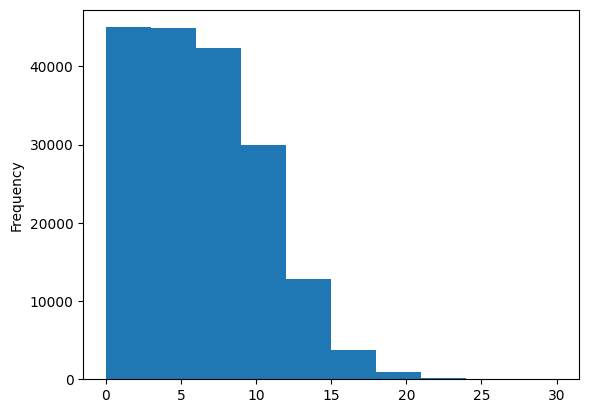

In [100]:
train_df['line_number'].plot.hist()

In [101]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [102]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [103]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

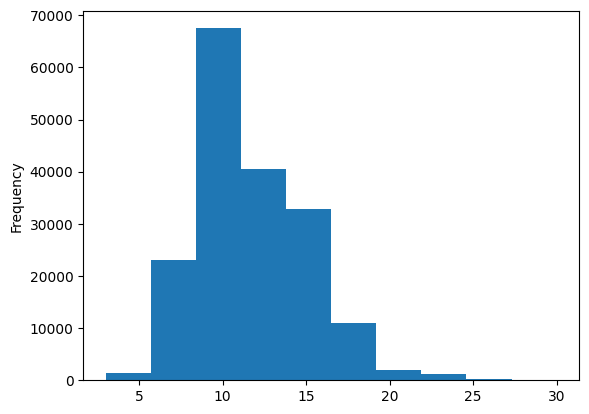

In [104]:
train_df['total_lines'].plot.hist()

In [105]:
np.percentile(train_df.total_lines, 98)

20.0

In [131]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)

In [132]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [138]:
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name = "line_number")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name = "total_lines")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embeddings")([line_number_model.output, total_line_model.output, z])

output_layer = layers.Dense(5, activation = "softmax", name="output_layer")(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input, 
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [139]:
model_5.summary()

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

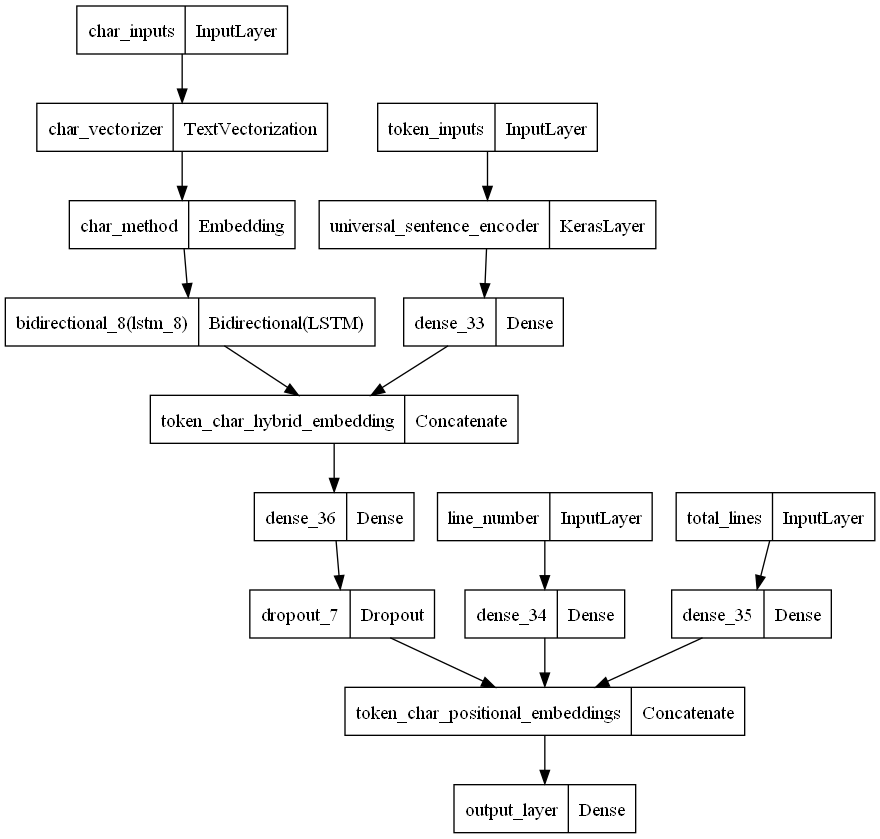

In [140]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [141]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [142]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [143]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 55s 91ms/step - loss: 1.0966 - accuracy: 0.7215 - val_loss: 0.9838 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 58s 103ms/step - loss: 0.9675 - accuracy: 0.8132 - val_loss: 0.9492 - val_accuracy: 0.8285
Epoch 3/3
562/562 [==============================] - 43s 77ms/step - loss: 0.9488 - accuracy: 0.8242 - val_loss: 0.9377 - val_accuracy: 0.8351


In [145]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 50s 49ms/step


array([[0.5043841 , 0.11654384, 0.01025478, 0.35394996, 0.01486738],
       [0.5107915 , 0.09130656, 0.03949223, 0.34661478, 0.011795  ],
       [0.28678507, 0.11944907, 0.11838061, 0.4252638 , 0.0501214 ],
       ...,
       [0.03499095, 0.10886291, 0.04628924, 0.02985116, 0.78000575],
       [0.03486712, 0.2733788 , 0.06137465, 0.02783429, 0.60254514],
       [0.17603017, 0.6619755 , 0.08486029, 0.03386769, 0.04326629]],
      dtype=float32)

In [146]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [147]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.29471733086191,
 'precision': 0.8317086384814673,
 'recall': 0.8329471733086191,
 'f1': 0.8321890520520234}

In [148]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.740236,0.784415,0.787402,0.784849
pretrained_token_embed,71.243215,0.713628,0.712432,0.709586
custom_char_embed_conv1d,65.126440,0.647102,0.651264,0.641073
hybrid_char_token_embed,73.537005,0.736011,0.735370,0.732799
tribrid_pos_char_token_embed,83.294717,0.831709,0.832947,0.832189


In [149]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

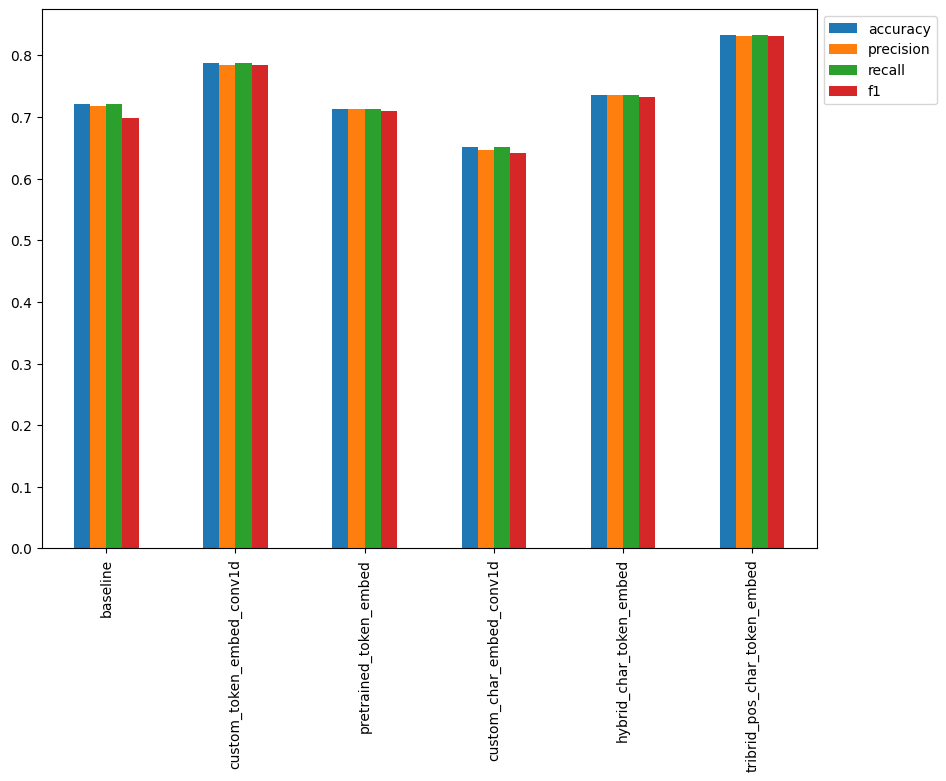

In [151]:
all_model_results.plot(kind="bar", 
                       figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

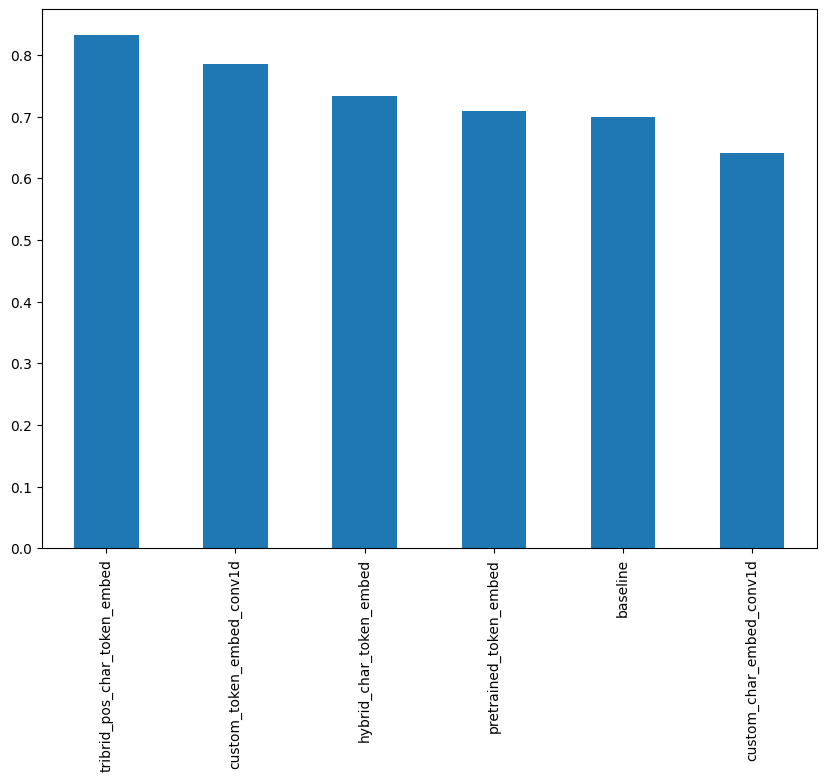

In [152]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", 
                                                                figsize=(10, 7))

In [153]:
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


In [156]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "./skimlit_tribrid_model/"

loaded_model = tf.keras.models.load_model(model_path)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

In [ ]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

In [ ]:
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

In [ ]:
loaded_model.summary()

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

In [ ]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

In [ ]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

In [ ]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

In [ ]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
    _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")